# We wish to implement a solver for non-local scalar conservation laws with the schemes presented in [E. Abreu et al., 2022]

A **nonlocal** scalar conservation law has the following form for $\rho : (x,t) \in\mathbb{R}\times [0, +\infty) \mapsto \rho(x,t) \in\mathbb{R}$

\begin{equation}
    \tag{NL-SCL}
    \partial_t \rho + \partial_x (f(\rho)V[\rho](x,t)) = 0 ,
\end{equation}

where typically $V = V_{\omega}$ has a convolution form 

\begin{align*}
V_{\omega}[\rho] (x, t)  & = v(\rho * \omega_{\eta} \,(x,t)) \\ 
            & = v\left(\int_{\mathbb{R}} dy\, \omega_{\eta}(x-y) \rho(y,t) \right),
\end{align*} 

for a suitably smooth kernel $\omega_{\eta} : \mathbb{R} \rightarrow \mathbb{R}$.

The associated Cauchy problem is 

\begin{equation}
    \begin{cases}
        \partial_t \rho(x,t) + \partial_x (f(\rho(x,t)) \,V_{\omega}[\rho](x,t)) = 0, \quad (x,t) \in \mathbb{R}\times (0,+\infty), \\
        \rho(x,0) = \rho_0(x), \quad x\in \mathbb{R}.
    \end{cases} 
\end{equation}

The existence and unicity of a weak entropy soution (see below)  is obtained under the following assumptions (cf. F.A. Chiarello et al. 2020) : 

- $\rho_0 \in \text{BV}(\mathbb{R}, I), \quad I =[\rho_{min}, \rho_{max}].$
- $f\in C^1(I, \mathbb{R}^+)$
- $v \in C^2(I, \mathbb{R}^+), \quad v' \leq 0.$
-  $\omega_{\eta} \in C^1([0,\eta], \mathbb{R}^+), \quad \omega' \leq 0, \quad \int_0^{\eta}\omega_{\eta} = 1, \quad \forall \eta > 0, \, \underset{\eta \rightarrow +\infty}{\lim} \omega_{\eta}(0) = 0.$

A **weak** solution of the Cauchy Problem (1) on the time interval $[0,T]$ is defined to be a function $\rho$ in a suitable function space such that for all $\phi\in C_c^{\infty}(\mathbb{R}\times(-1, T))$, there holds 

\begin{equation}
\tag{W}
\int_{0}^T\int_{\mathbb{R}} dt dx\,(\rho(x,t) \,\partial_t\phi(x,t) + f(\rho(x,t)) V_{\omega}[\rho](x,t)\,\partial_x\phi(x,t)) + \int_{\mathbb{R}} dx\,\rho_0(x) \phi(x,0) = 0.
\end{equation}

Assuming $f(\rho) = \rho$, and according to the condition proved by Kruzkov, a **weak entropy** solution of the Cauchy problem (1) on the time interval $[0,T]$ is defined to be a function $\rho$ in a suitable function space such that for all $\phi\in C_c^{\infty}(\mathbb{R}\times(-1, T))$ and all $\kappa\in\mathbb{R}$, there holds

\begin{equation}
\tag{WE}
    \int_{0}^T \int_{\mathbb{R}} dtdx\, \left( |\rho(x,t) - \kappa| \,\partial_t\phi(x,t) + |\rho(x,t) - \kappa| \,V_{\omega}[\rho](x,t)\,\partial_x \phi(x,t) - \text{sgn}(\rho(x,t) - \kappa)\,V_{\omega}[\rho](x,t) \,\phi(x,t) \right) 
    + \int_{\mathbb{R}} dx\,|\rho_0(x) - \kappa|\,\phi(x,0) \geq 0 .
\end{equation} 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

### Initial condition 

In [2]:
sigma_0 = 0.5
µ_0 = np.pi
rho_0 = lambda x: 4 * (1/(7*np.pi)**0.5) * np.exp(-x**2/7)

In [3]:
# rho_0 = lambda x: 0.4 if x<0 else 0.9

## Flux

In [4]:
f = lambda x: 0.5*x**2 

### Chosen Kernel

In [5]:
# µ_w = 1
# sigma_w = 0.3
# w = lambda x: np.exp(-0.5*(sigma_w**-2)*((x-µ_w)**2))

In [6]:
eta = 0.5
w = lambda x: 1/eta 

### Velocity

In [7]:
v = lambda x: 1-x

We discretize the space as $\{x_j^0\}_{j = 0, \cdots, \,N-1} = \{j\Delta x^0\}_{j=0, \cdots, \,N-1}$ with $\Delta x^0 = x_{\text{max}}/N$.

We also define the *no-flow curves* $\sigma^n_j$ such that $\sigma_j^n(t^n) = x_j^n$. Notice that the grid elements $x_j^n$ depend on time since they will not be uniform (that is, equally spaced) and are evolving according to the $\sigma$ curves. Following this remark we are to define the non-uniform space step

$$ (\Delta x)_{j}^{n+1} \hat{=} \, \bar{x}_{j+1/2}^{n+1} - \bar{x}_{j-1/2}^{n+1}, $$

having defined $\bar{x}_{j+1/2}^{n+1} = \sigma_{j+1}^n(t^{n+1})$ and $\bar{x}_{j-1/2}^{n+1} = \sigma_j^n(t^{n+1})$. 

Now, the *sigma* curves correspond to the characteristic curves of equation (1), so that they obey the following ODE : 

\begin{equation}
    \tag{C}
    \begin{cases}
        \dfrac{d\,\sigma_j^n}{dt}(t) & = \dfrac{f(\rho(\sigma_j^n(t), t))}{\rho(\sigma_j^n(t), t)} \, V_{\omega}[\rho](\sigma_j^n(t), t), \quad \text{for} \quad t^n < t \leq t^{n+1}, \\ 
        \sigma_j^n(t^n) & = x_j^n.
    \end{cases}
\end{equation} 

We now present the different approximations considered to obtain a numerical scheme.

1 ) The solution of (C) will be approximated using an explicit Euler method in time so that 

\begin{equation}
    \tag{E}
    \sigma_{j}^n(t) \sim x_j^n + (t-t^n) \dfrac{f_j^n}{\rho_j^n}\, V_j^n,
\end{equation}

denoting  $\rho_j^n = \rho(\sigma_j^n(t^n), t^n)$, $\,f_j^n = f(\rho_j ^n)$ and  $V_j^n = V_{\omega}[\rho^n](\sigma_j^n(t^n), t^n)$.

From (E), we deduce the evolution of the space step, 

\begin{align*}
(\Delta x)_j^{n+1} & = \bar{x}_{j+1/2}^{n+1} - \bar{x}_{j-1/2}^{n+1} \\
                    & = (\Delta x)_j^{n} + \Delta t \left( \dfrac{f_{j+1}^n}{\rho_{j+1}^n}\, V_{j+1}^n - \dfrac{f_j^n}{\rho_j^n}\, V_j^n \right)
\end{align*}



2 ) Regarding the (upstream) convolution term, we make the approximation, for $v(x) = 1-x$,

$$ V_j^n \sim 1 - (\Delta x)_j^n \sum\limits_{k=-N+1}^0 \omega_{\eta}^k\, \rho_{j+k}^n, \quad \text{with} \quad \omega_{\eta}^k = \omega_{\eta}(k(\Delta x)_j^n). $$ 

3 ) When it comes to $\rho$ we first make the approximation 

$$ \bar{\rho}_{j}^{n+1} = \dfrac{(\Delta x)_j^n}{(\Delta x)_j^{n+1}}\left( \dfrac{\rho_j^n + \rho_{j+1}^n}{2}\right), $$ 

and project these approximations on the original grid to obtain 

$$ \rho_{j}^{n+1} = \left( \frac{1}{2} + \frac{(\Delta t)}{(\Delta x)_{j}^n}\frac{f_j^n}{\rho_j^n}\, V_j^n \right) \, \bar{\rho}_{j-1}^{n+1} + \left( \frac{1}{2} - \frac{(\Delta t)}{(\Delta x)_{j}^n}\frac{f_j^n}{\rho_j^n}\, V_j^n \right) \, \bar{\rho}_{j}^{n+1}. $$

4 ) Finally we deduce the scheme 

\begin{equation}
    \tag{S}
    \rho_{j}^{n+1} = \frac{\rho_{j-1}^n + 2 \rho_j^n + \rho_{j+1}^n}{4} + \frac{\Delta t}{4}\left[ \frac{1}{(\Delta x)_{j-1}^{n+1}}\left( \frac{f_{j-1}^n V_{j-1}^n}{\rho_{j-1}^n} + \frac{f_j^n V_j^n}{\rho_j^n} \right) (\rho_{j-1}^n + \rho_j^n) - \frac{1}{(\Delta x)_{j}^{n+1}} \left( \frac{f_j^n V_j^n}{\rho_j^n} + \frac{f_{j+1}^n V_{j+1}^n}{\rho_{j+1}^n} \right)(\rho_j^n + \rho_{j+1}^n)     \right],
\end{equation} 

which simplifies, in the case $f(\rho) = \rho$, to 

\begin{equation}
    \tag{I-S}
    \rho_j^{n+1} = \frac{\rho_{j-1}^n + 2 \rho_j^n + \rho_{j+1}^n}{4} + \frac{\Delta t}{4} \left[ \frac{1}{(\Delta x)_{j-1}^{n+1}}\, (V_{j-1}^n + V_j^n)(\rho_{j-1}^n + \rho_j^n) - \frac{1}{(\Delta x)_j^{n+1}}\, (V_j^n + V_{j+1}^n) (\rho_j^n + \rho_{j+1}^n)    \right].
\end{equation}

In the paper (cf. Theorem 2.1) the scheme $(\text{I-S})$ is proved to converge towards the unique weak entropy solution of (1) for $\rho_0 \in \text{BV}(\mathbb{R})$ under the following CFL condition : 

\begin{equation}
    \tag{CFL}
    |V_j^n| \leq \frac{1}{8}\frac{(\Delta x)_j^n}{\Delta t} \quad \text{for }\, j \in \{0, \cdots, N-1\}, \, n \in \mathbb{N}^*.
\end{equation}

We simplify the CFL to 

\begin{equation}
    \tag{CFL}
    \underset{j,n}{\max}\,|V_j^n| \leq \frac{1}{8} \frac{1}{\Delta t} \underset{j,n}{\max}\,(\Delta x)_j^n  
\end{equation}

In [8]:
N = 200
xmax = 2*np.pi
xmin = 0
_dx = xmax/N
x = np.array([j*_dx + 0.5*_dx for j in range(N)])
dx = [_dx] * (N-1)

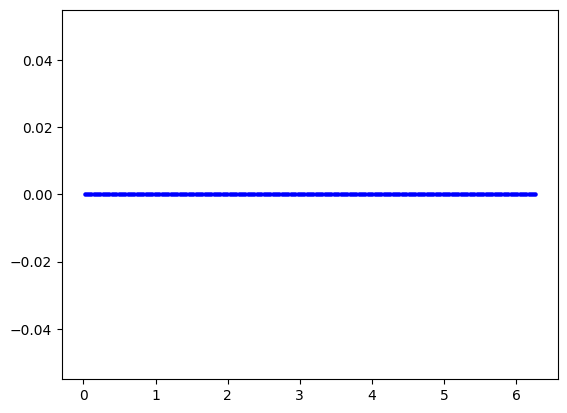

In [9]:

plt.scatter(x, np.zeros(N), c='blue', s=5)

In [10]:
# plt.plot(x, list(map(w, x)))

In [11]:
def compute_upstream_convolution_approx(x, w, rho_n, dx, j):
    N = len(x) 
    _w = [w(k*dx[j]) for k in np.arange(-N+1, 1)]
    to_sum = [] 
    for k in np.arange(-N+1, 1):
        if j+k >=0:
            rho_term = rho_n[j+k]
        else:
            rho_term = rho_n[N-1+j+k]
        to_sum.append(_w[k+N-1]*rho_term)
    to_sum = np.array(to_sum)
    return v(dx[j] * np.sum(to_sum))

def upstream_conv_approx(x, w, rho_n, dx):
    N = len(x)
    return np.array(
        [compute_upstream_convolution_approx(x, w, rho_n, dx, j)
         for j in range(N-1)]
    )

In [12]:
def compute_downstream_convolution_approx(x, w, rho_n, dx, j):
    N = len(x) 
    _w = [w(k*dx[j]) for k in range(N)]
    to_sum = [] 
    for k in range(N):
        if j+k <= N-1:
            rho_term = rho_n[j+k]
        else:
            rho_term = rho_n[-(N-1)+j+k]
        to_sum.append(_w[k]*rho_term)
    to_sum = np.array(to_sum)
    return v(dx[j] * np.sum(to_sum))

def downstream_conv_approx(x, w, rho_n, dx):
    N = len(x)
    return np.array(
        [compute_downstream_convolution_approx(x, w, rho_n, dx, j)
         for j in range(N-1)]
    )

In [13]:
rho_zero = list(map(rho_0, x))

In [14]:
# plt.plot(rho_zero)

In [15]:
V_zero = upstream_conv_approx(x, w, rho_zero, dx)
V_zero_down = downstream_conv_approx(x, w, rho_zero, dx) 

In [16]:
def evolve_space_step(x, dx, dt, V_n):
    N = len(x) 
    new_dx = dx
    new_dx[:N-2] = np.array(
        [dx[j] + dt * (V_n[j+1] - V_n[j])
        for j in range(N-2)]
    )
    return new_dx 

In [17]:
def evolve_space_step_f(x, dx, dt, V_n, rho_n, f):
    N = len(x) 
    new_dx = dx 
    new_dx[:N-2] = np.array(
        [dx[j] + dt * (f(rho_n[j+1])*V_n[j+1]*rho_n[j+1]**-1
                        - f(rho_n[j])*V_n[j]*rho_n[j]**-1)
        for j in range(N-2)]
    )
    return new_dx

In [18]:
dx_one = evolve_space_step_f(x, dx, 1e-2, V_zero, rho_zero, f)

In [19]:
def locally_update_rho(rho_n, new_dx, dt, V_n, j):
    new_rho = (rho_n[j-1] + 2*rho_n[j] + rho_n[j+1]) / 4 
    new_rho += (dt/4) * (
        (new_dx[j-1]**-1) * (V_n[j-1] + V_n[j]) * (rho_n[j-1] + rho_n[j])
        - (new_dx[j+1]**-1) * (V_n[j] + V_n[j+1]) * (rho_n[j] + rho_n[j+1])
    )
    return new_rho

def update_rho(x, rho_n, new_dx, dt, V_n):
    N = len(x)
    new_rho = np.copy(rho_n)
    new_rho [1:N-2] = np.array(
        [locally_update_rho(rho_n, new_dx, dt, V_n, j)
         for j in range(1,N-2)]
    )
    ### Absorbing BC : extending the solution constantly on the right boundary 
    last_value = new_rho[N-3]
    new_rho[N-2:] = np.array([last_value]*2)
    return new_rho

In [20]:
# a = 2
# if a == 2:
#     print('in it')
# else:
#     pass 
# print('out')

In [21]:
def locally_update_rho_f(rho_n, new_dx, dt, V_n, f, j):
    new_rho = (rho_n[j-1] + 2*rho_n[j] + rho_n[j+1]) / 4 
    if (rho_n[j-1]) != 0 and (rho_n[j] != 0) and (rho_n[j+1] != 0):
        new_rho += (dt/4) * (
            (new_dx[j-1]**-1) * (f(rho_n[j-1])*V_n[j-1]*rho_n[j-1]**-1 + f(rho_n[j])*V_n[j]*rho_n[j]**-1) * (rho_n[j-1] + rho_n[j])
            - (new_dx[j+1]**-1) * (f(rho_n[j])*V_n[j]*rho_n[j]**-1 + f(rho_n[j+1])*V_n[j+1]*rho_n[j+1]**-1) * (rho_n[j] + rho_n[j+1])
        )
    else:
        pass
    return new_rho

def update_rho_f(x, rho_n, new_dx, dt, V_n,f):
    N = len(x)
    new_rho = np.copy(rho_n)
    new_rho [1:N-2] = np.array(
        [locally_update_rho_f(rho_n, new_dx, dt, V_n, f, j)
         for j in range(1,N-2)]
    )
    ### Absorbing BC : extending the solution constantly on the right boundary 
    last_value = new_rho[N-3]
    new_rho[N-2:] = np.array([last_value]*2)
    return new_rho

In [22]:
# plt.plot(dx_one)

In [23]:
rho_one = update_rho(x, rho_zero, dx_one, 1e-2, V_zero)

In [24]:
f = lambda x:x 

In [25]:
rho_one_test = update_rho_f(x, rho_zero, dx_one, 1e-2, V_zero, f)

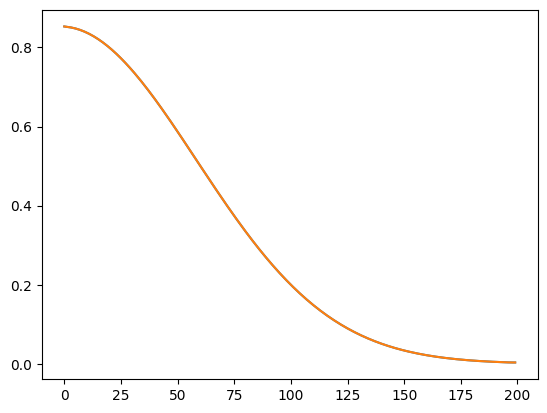

In [26]:
plt.plot(rho_one)
plt.plot(rho_one_test)

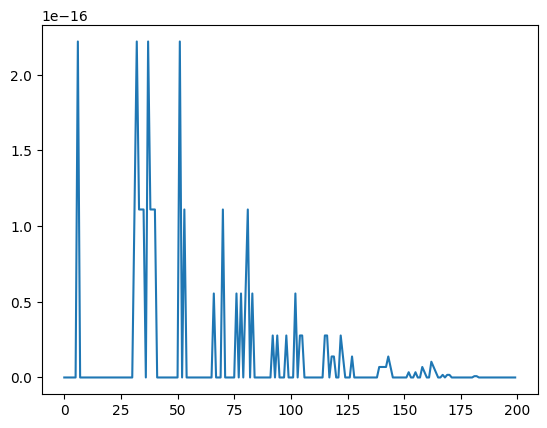

In [27]:
plt.plot(np.abs(rho_one - rho_one_test))

In [28]:
class lagrangian_eulerian_solver:
    
    def __init__(self, v, w, f, N, x_max, x_min, dt, convolution='upstream'):

        self._dx = (x_max - x_min) / N
        self.dx_zero = [self._dx] * (N-1)
        self.x = [x_min + j*self._dx for j in range(N)]
        self.v = v 
        self.w = w 
        self.dt = dt
        self.sol = [] 
        self.f = f 
        self.convolution_method = convolution
    
    def initialisation(self, rho_0):
        self.rho_zero = np.array(
            list(map(rho_0, self.x))
        )
        if self.convolution_method == 'upstream':
            self.V_zero = upstream_conv_approx(self.x, self.w, self.rho_zero, self.dx_zero)
        elif self.convolution_method == 'downstream':
            self.V_zero = downstream_conv_approx(self.x, self.w, self.rho_zero, self.dx_zero)
        else:
            raise Exception(
                'no other convolution method implemented : choose upstream or downstream'
                )

        self.sol.append(self.rho_zero)
        
    
    def solve(self, T):
        self.dx  = self.dx_zero
        self.rho = self.rho_zero
        self.V = self.V_zero
        
        n_iterations = int(T/self.dt) 
        
        for n in range(n_iterations):

            if self.convolution_method == 'upstream':
                new_V = upstream_conv_approx(self.x, self.w, self.rho, self.dx)
            elif self.convolution_method == 'downstream':
                new_V = downstream_conv_approx(self.x, self.w, self.rho, self.dx)
            else:
                raise Exception(
                    'no other convolution method implemented : choose upstream or downstream'
                    )
             
            new_dx = evolve_space_step_f(self.x, self.dx, self.dt, self.V, self.rho, self.f)
            new_rho = update_rho_f(self.x, self.rho, new_dx, self.dt, new_V, self.f)

            if n % (n_iterations//10) == 0:
                print('CFL :')
                print('max_j V_n = {}'.format(np.max(np.abs(new_V))))
                print('RHS = {}'.format((1/8) * np.max(new_dx) / self.dt))
                print('')

            self.sol.append(new_rho)
            self.V = new_V 
            self.dx = new_dx 
            self.rho = new_rho


In [29]:
# rho_0 = lambda x: 4 * ((7*np.pi)**-0.5) * np.exp(-x**2/7)

In [30]:
# rho_0 = lambda x: 0.4 if x<0 else 0.9

In [31]:
rho_0 = lambda x: 1.0 if (x>=0) and (x<1) else 1e-12

In [32]:
# eta = 0.5
# w = lambda x : eta**-1

In [33]:
K = lambda x: 3/8 * (1 - x**2 /4) if (x>-2) and (x<2) else 0.0

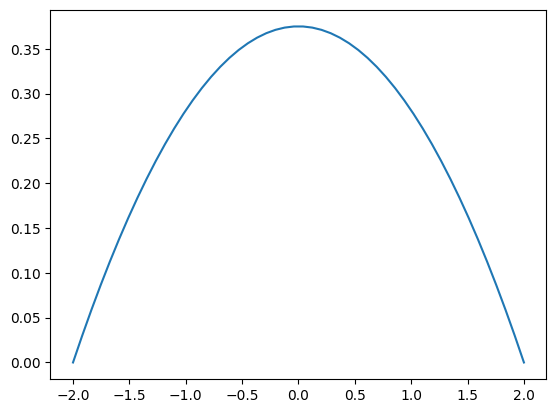

In [34]:
_x = np.linspace(-2, 2)
plt.plot(_x, list(map(K,_x)))

In [35]:
# w = lambda x: 1.0 if (x>0) and (x<1) else 0.0
eta = 1.0 


In [36]:
f = lambda x: x * (1-x)

In [37]:
v = lambda x: (1 -x) ** 4 

In [38]:
rho_0 = lambda x: 0.01 if x>0.2 else 0.0 

In [39]:
N = 1500
dt = N**-1/4
solver = lagrangian_eulerian_solver(v, w, f, N=N, x_max=4.0, x_min=0.0, dt=dt, convolution='downstream')
solver.initialisation(rho_0)
print(solver._dx/solver.dt)

16.0


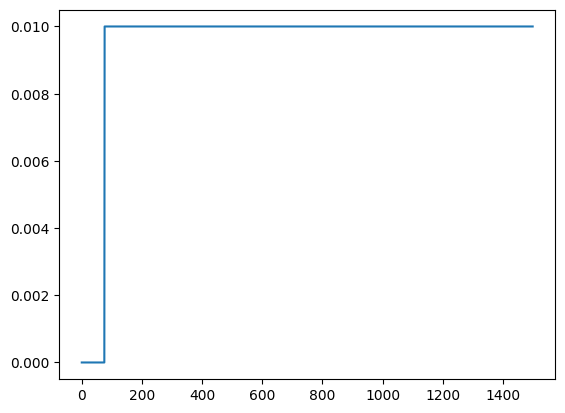

In [40]:
plt.plot(solver.rho_zero)

In [41]:
T = 0.01
solver.solve(T)

/tmp/ipykernel_10866/4135024331.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  [dx[j] + dt * (f(rho_n[j+1])*V_n[j+1]*rho_n[j+1]**-1
/tmp/ipykernel_10866/4135024331.py:5: RuntimeWarning: invalid value encountered in double_scalars
  [dx[j] + dt * (f(rho_n[j+1])*V_n[j+1]*rho_n[j+1]**-1
/tmp/ipykernel_10866/4135024331.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  - f(rho_n[j])*V_n[j]*rho_n[j]**-1)
/tmp/ipykernel_10866/4135024331.py:6: RuntimeWarning: invalid value encountered in double_scalars
  - f(rho_n[j])*V_n[j]*rho_n[j]**-1)


CFL :
max_j V_n = 0.8565415639782875
RHS = nan

CFL :
max_j V_n = nan
RHS = nan

CFL :
max_j V_n = nan
RHS = nan



KeyboardInterrupt: 

In [ ]:
real_rho = lambda x,t : 1*(1-t)**-1 if (x>t) and (x<1) else 0.0

In [ ]:
len(solver.sol)

1849

In [ ]:
T/dt

2400.0

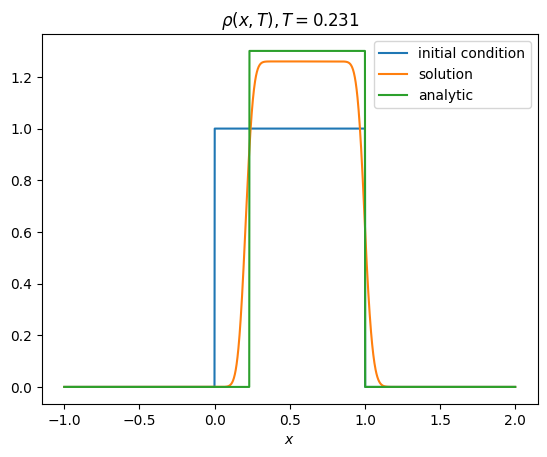

In [ ]:
plt.title(r'$\rho(x,T), T={}$'.format(round(dt*len(solver.sol),3)))

plt.plot(solver.x, solver.rho_zero, label='initial condition')
plt.plot(solver.x, solver.sol[-1], label='solution')
plt.plot(solver.x, list(map(lambda x: real_rho(x, len(solver.sol)*dt), solver.x)), label='analytic')
plt.xlabel(r'$x$')
plt.legend()

plt.savefig('./graphs/rectangle_N={}_dt={}_T={}.png'.format(N, round(dt,3), T))

In [ ]:
1/0

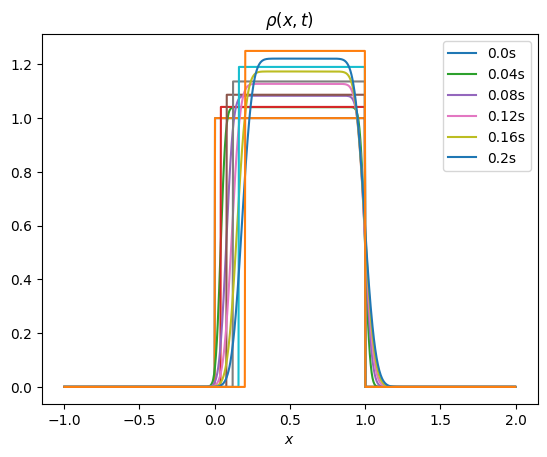

In [ ]:
n_curves = 5

for i in range(len(solver.sol)):
    if i % (len(solver.sol)//n_curves) == 0:
        plt.title(r'$\rho(x,t)$')
        plt.plot(solver.x, solver.sol[i], label='{}s'.format(round(i*dt,3)))
        plt.plot(solver.x, list(map(lambda x: real_rho(x, i*dt), solver.x)))
        plt.xlabel(r'$x$')

plt.legend()
plt.savefig('./graphs/rectangle_example_N={}_dt={},T={}.png'.format(N, round(dt,3), T))
